Homework 5

UNSUPERVISED LEARNING

Instructions

We will work with a data set that contains transactions for an online retail store based in UK.

The data is available in the UCI repository([Online Retail - UCI Machine Learning
Repository](https://archive.ics.uci.edu/dataset/352/online+retail)).

We are tasked with doing customer segmentation analyses. T o that end, we'll
need to apply some clustering algorithms to analyse the data set and see if we can find something interesting.

Therefore, your instructions are the following:

1. Download the data set, read it in Python, and get familiar with it. What are the
columns, descriptive statistics, null counts, value counts, etc. There are approx. 430
customers that are non-UK and 3,950 that are UK-based. There are 8 customers
which have transactions from more than one country. Find, then remove those 8
customers and work with the remaining 4,372.
2. The dataset contains individual transactions, but to do customer segmentation, you'll need to group data by customers. You can group data by customer ID and aggregate individual transaction values (e.g., total amount spent per customer, total items purchased). This step is the data
preprocessing step, so make sure that your grouped data can be fed into a clustering
algorithm.
3. Apply an agglomerative clustering algorithm, use either the implementation from
sklearn or scipy.

  3.1 Try different values for the linkage (sklearn) / method (scipy) parameter.
  Evaluate which one yields the highest Sillhouete score and with that setting, plot a
  dendrogram of the clustering.
4. Apply the KMeans algorithm. Find the optimal value for the parameter k through an
elbow plot), plotting the different values for k on the x-axis (try k = [2,3,4, 5, ... 20] )
and the inertia
_ property on the y-axis. Interpret the plot and state what's the optimal
value for k from the ones tested.

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, fcluster
from scipy.cluster.hierarchy import linkage
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

In [5]:
df = pd.read_excel("Online Retail.xlsx")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [8]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [9]:
df['Country'].value_counts()

,count
Country,
United Kingdom,495478
Germany,9495
France,8557
EIRE,8196
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,2002
Portugal,1519


In [10]:
multi_country_customers = df.groupby('CustomerID')['Country'].nunique()
multi_country_customers = multi_country_customers[multi_country_customers > 1].index
print(multi_country_customers.shape)

df_cleaned = df[df['CustomerID'].apply(lambda x: x not in multi_country_customers)]

print()
print(df_cleaned.shape)

(8,)

(540983, 8)


In [11]:
df_cleaned = df_cleaned.dropna(subset=['CustomerID'])

In [12]:
df_cleaned.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


###2

In [13]:
#total spend
df_cleaned['TotalSpend'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

snapshot_date = df_cleaned['InvoiceDate'].max() + datetime.timedelta(days=1)

customer_data = df_cleaned.groupby('CustomerID').agg({
    'TotalSpend': 'sum',
    'Quantity': 'sum',
    'InvoiceNo': 'nunique',
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days
}).reset_index()

customer_data.columns = ['CustomerID', 'Monetary', 'Frequency', 'Transactions', 'Recency']

In [14]:
customer_data.isnull().sum()

customer_data = customer_data.dropna()

customer_data = customer_data[customer_data['Monetary'] > 0]
customer_data = customer_data[customer_data['Frequency'] > 0]

In [15]:
#scale the data
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[['Monetary', 'Frequency', 'Recency']])

###3

In [16]:
linkage_methods = ['ward', 'complete', 'average', 'single']
silhouette_scores = []

for linkage_method in linkage_methods:
    agg_clust = AgglomerativeClustering(linkage=linkage_method)
    clusters = agg_clust.fit_predict(customer_data_scaled)
    silhouette_avg = silhouette_score(customer_data_scaled, clusters)
    silhouette_scores.append(silhouette_avg)
    print(f"Linkage: {linkage_method}, Silhouette Score: {silhouette_avg}")

#method with the highest silhouette score
best_linkage = linkage_methods[silhouette_scores.index(max(silhouette_scores))]
print(f"Best linkage method: {best_linkage}")

Linkage: ward, Silhouette Score: 0.952677049649554
Linkage: complete, Silhouette Score: 0.9744006356322016
Linkage: average, Silhouette Score: 0.9744006356322016
Linkage: single, Silhouette Score: 0.9744006356322016
Best linkage method: complete


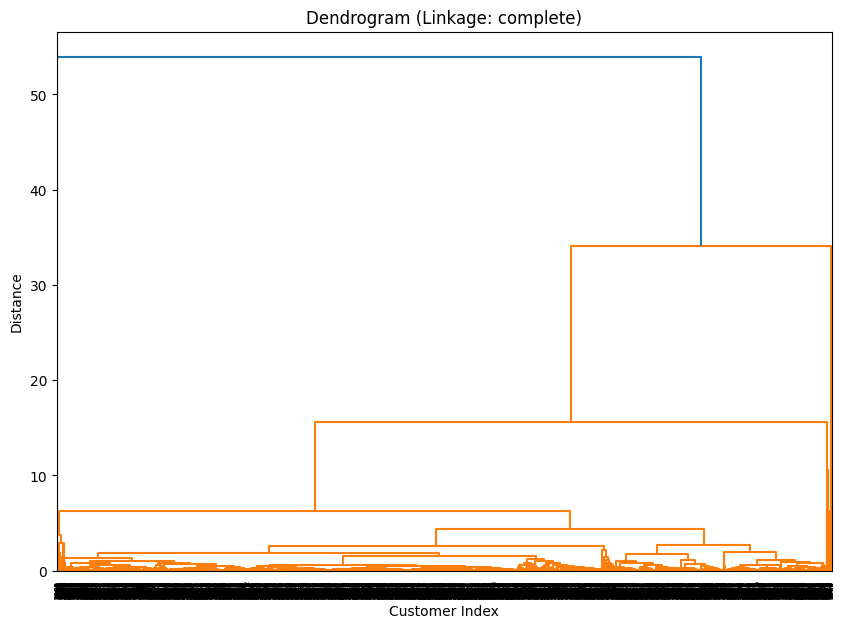

In [17]:
Z = linkage(customer_data_scaled, method=best_linkage)

#plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title(f'Dendrogram (Linkage: {best_linkage})')
plt.xlabel('Customer Index')
plt.ylabel('Distance')
plt.show()

###4

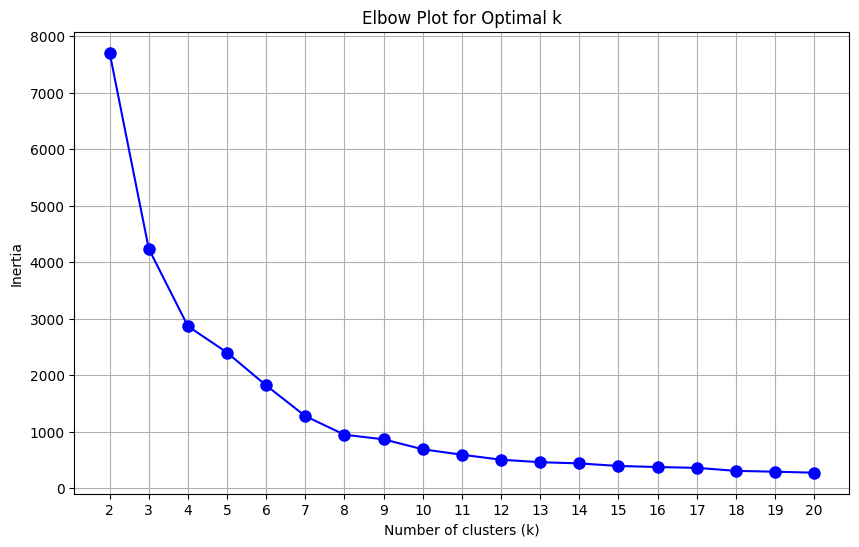

In [18]:
k_values = range(2, 21)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia_values.append(kmeans.inertia_)

#plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Plot for Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

###optimal value for k is 5